## Analytic maximum likelihood scaled transit fit

We can use a factor $s$ to modifiy the transit depth in a nominal model ${\bf m_0}$ calculated with approximately the correct depth that is scaled as follows ...

$ {\bf m}(s) = 1 + s\times({\bf m_0}- 1)$

The data are normalised fluxes ${\bf f} = f_1, \dots, f_N$ with nominal errors ${\bf \sigma} = \sigma_1,\dots, \sigma_N$. 

Assume that the actual standard errors are underestimated by some factor $b$, and that these are normally distributed and uncorrelated, so that the log-likelihood is

$\ln {\cal L}  = -\frac{1}{2b^2}\chi^2 - \frac{1}{2}\sum_{i=1}^N \ln \sigma_i^2  - N\ln b - \frac{N}{2}\ln(2\pi)$

where

$\chi^2 = \sum_i^N \frac{(f_i - 1 - s(m_{0,i}-1)^2}{\sigma_i^2} $


The maximum likelihood occurs for parameter values $\hat{s}$, and $\hat{b}$ such that

$\left. \frac{\partial  \ln {\cal L}}{\partial s}\right|_{\hat{s},\hat{b}} = 0$
and 
$\left. \frac{\partial  \ln {\cal L}}{\partial b}\right|_{\hat{s},\hat{b}} = 0$,

from which we obtain 

 $\hat{s} = \sum_{i=1}^N \frac{(f_i - 1)(m_{0,i}-1) }{\sigma_i^2} \left[ \sum_{i=1}^N \frac{(m_{0,i}-1)^2}{\sigma_i^2}\right]^{-1}$
 
 and 
 
 $\hat{b} = \sqrt{\chi^2/N}$
 
 For the standard errors on these parameters we use 
 
 $\sigma_s^{-2}  = -\frac{\partial^2\ln{\cal L}}{\partial^2 s^2} \left.\right|_{\hat{s},\hat{b}}$ 
 
 and
 
 $\sigma_b^{-2}  = -\frac{\partial^2\ln{\cal L}}{\partial^2 b^2} \left.\right|_{\hat{s},\hat{b}}$ 

to derive

$\sigma_s = b\left[\sum_{i=1}^N \frac{(m_i-1)^2}{\sigma_i^2}\right]^{-1/2}$
 
 and
 
 $\sigma_b  = \left[3\chi^2/b^4 -N/b^2\right]^{-1/2} .$
 
**N.B.** Whether or how much of the data outside transit to include depends on whether these data can be assumed to have the same noise characteristics as the data in transit. Note that including these data has no effect on $s$ or $\sigma_s$, because of the factors $(m_{0,i}-1)$ in their calculation, but will affect the estimates of $b$ and $\sigma_b$.


In [1]:
%pylab inline
from pycheops.models import TransitModel, scaled_transit_fit
from pycheops.instrument import transit_noise


Populating the interactive namespace from numpy and matplotlib


ImportError: cannot import name 'scaled_transit_fit'

#### Load simulated data and clean out CRs

 As a heuristic approach to setting a limit to reject cosmic rays we use the most negative value in the observed data.

Read 2615 observations
C_cut = 3515101, N(C > C_cut = 85)
Mean counts = 3507779.2
Median counts = 3507211.2
RMS counts = 3790.9 [1081 ppm]
Median standard error = 1954.5 [557 ppm]


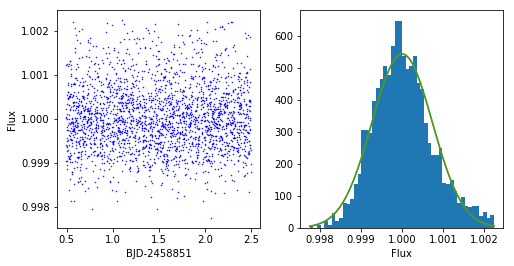

In [3]:
T = Table.read('CH_PR300005_TG000201_TU2020-01-02T23-44-04_SCI_COR_Lightcurve-OPTIMAL_V0000.fits')
N_obs = len(T)
print('Read {} observations'.format(N_obs))
ok = (T['EVENT'] == 0)  |  (T['EVENT'] == 100)
BJD = np.array(T['BJD_TIME'][ok])
C = np.array(T['FLUX'][ok])
Cerr = np.array(T['FLUXERR'][ok])

C_cut = (2*median(C)-min(C))
Ecr = C[C > C_cut] - median(C)
E_cut = C_cut - median(C)
N_cut = len(Ecr)
Ecr.sort()
print('C_cut = {:0.0f}, N(C > C_cut = {})'.format(C_cut, N_cut))

print('Mean counts = {:0.1f}'.format(C.mean()))
print('Median counts = {:0.1f}'.format(median(C)))
print('RMS counts = {:0.1f} [{:0.0f} ppm]'.format(std(C), 1e6*std(C)/np.median(C)))
print('Median standard error = {:0.1f} [{:0.0f} ppm]'.format(np.median(Cerr), 1e6*np.median(Cerr)/np.median(C)))

time_raw = BJD[C < C_cut]-int(min(BJD))
flux_raw = C[C < C_cut]/median(C)
flux_err = Cerr[C < C_cut]/median(C)

fig,ax=subplots(1,2,figsize=(8,4))
ax[0].plot(time_raw, flux_raw,'b.',ms=1)
ax[0].set_xlabel("BJD-{}".format(int(min(BJD))))
ax[0].set_ylabel("Flux".format(median(C)));

n, bins, patches = ax[1].hist(flux_raw, 50, normed=True)
ax[1].set_xlabel("Flux".format(median(C)));
v  = np.var(flux_raw)
ax[1].plot(bins,exp(-0.5*(bins-1)**2/v)/sqrt(2*np.pi*v));
ax[1].plot(bins,exp(-0.5*(bins-1)**2/v)/sqrt(2*np.pi*v));



**N.B.** we have normalized the data using the median of the data here. There is a noticable offset between the mean and median values due to the tail in the distribution of the observed counts values.

#### Inject a transit

This will be the reference model ${\bf m_0}$. Use a transit depth $D = 85\,$ppm and a transit width $W=3\,$hours based on the parameters for SciReq 1.2. For simplicity using impact parameter $b=0$. Use limb darkening appropriate for a K-type dwarf and an orbital period of 13 days star since this is the case under consideration for SciReq 1.2.




In [4]:
WIDTH_HOURS = 3
DEPTH_PPM = 85
PERIOD = 13


T_0 = 1.5
D = DEPTH_PPM*1e-6  # Set transit depth
W = WIDTH_HOURS/24/PERIOD  # Transit Width in phase units
b = 0 # Impact parameter S is the ratio (W_23 / W_14)**2 = ((1-k**2)-b**2)/((1+k)**2-b**2) 
k = sqrt(D)  # Ratio of the radii
S = ((1-k)**2-b**2)/((1+k)**2-b**2)  # Transit Shape
print('R_p/R_* = {:0.4f}, S = {:0.2f}'.format(k, S))
c = 1.0    # Flux outside transit

T_eff = 4800
log_g = 4.5
Fe_H = 0
p2C = stagger_power2_interpolator(passband='CHEOPS')
c2,a2,h1,h2 = p2C(T_eff, log_g, Fe_H)
print('h_1 = {:0.3f}, h_2 = {:0.3f}'.format(h1, h2))


R_p/R_* = 0.0092, S = 0.96
h_1 = 0.680, h_2 = 0.432


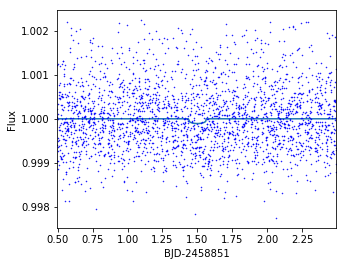

In [5]:
model = TransitModel()
pars0 = model.make_params(T_0=T_0, P=PERIOD, D=D, W=W, S=S, h_1=h1, h_2=h2)
model_0 = model.eval(params=pars0, t=time_raw) 

fig,ax=subplots(1,1,figsize=(5,4))
ax.plot(time_raw, model_0)
ax.set_xlim(min(time_raw),max(time_raw))

flux_sim = flux_raw * model_0
ax.plot(time_raw, flux_sim,'b.',ms=1)
ax.set_xlabel("BJD-{}".format(int(min(BJD))))
ax.set_ylabel("Flux".format(median(C)));


### Fit the transit using only in-transit data

In [6]:
j = (np.abs(time_raw-T_0) < (WIDTH_HOURS/24)).nonzero()[0]

s0, b0, sigma_s0, sigma_b0 = scaled_transit_fit(flux_sim[j],flux_err[j],model_0[j])
print('Transit scale factor s = {:0.2f} +/- {:0.2f}'.format(s0, sigma_s0))
print('Error scale factor  b = {:0.2f} +/- {:0.2f}'.format(b0, sigma_b0))
depth0 = s0*DEPTH_PPM*1e-6
e_depth0 = sigma_s0*DEPTH_PPM*1e-6
print('Depth = {:0.0f} +/- {:0.0f} ppm'.format(depth0*1e6, e_depth0*1e6))


Transit scale factor s = 0.78 +/- 0.62
Error scale factor  b = 1.35 +/- 0.05
Depth = 66 +/- 53 ppm


#### Iteration step

Now find depth that gives S/N = 1


In [7]:
depth_tol = 0.5e-6
depth_in = 0
e_depth = e_depth0
while abs(e_depth-depth_in) > depth_tol:
    depth_in = e_depth
    k = sqrt(depth_in)
    S = ((1-k)**2)/((1+k)**2)  
    pars = model.make_params(T_0=T_0, P=PERIOD, D=depth_in, W=W, S=S, h_1=h1, h_2=h2, c=c)
    model_1 = model.eval(params=pars, t=time_raw)
    s1, b1, sigma_s1, sigma_b1 = scaled_transit_fit(flux_sim[j],flux_err[j],model_1[j])
    depth = s1*depth_in
    e_depth = sigma_s1*depth_in
    
print('Noise in {} hour window at t={:0.1f} from (S/N=1) transit depth =  {:0.1f} ppm'
      .format(WIDTH_HOURS, T_0,1e6*depth_in))
print('Noise scaling factor = {:0.2f}'.format(b1))


Noise in 3 hour window at t=1.5 from (S/N=1) transit depth =  52.6 ppm
Noise scaling factor = 1.35


### Noise estimate in moving window

Define a function to do all this in one call

In [8]:
def transit_noise(time, flux, flux_err, T_0=None, width=3, 
                  h_1=0.7224, h_2=0.6713, 
                  tol=0.1, verbose=None):
    """ 
    Transit noise estimate
    
    The noise is calculated in a window of width duration in hours 
    centered at time T_0 by finding the depth of a transit that gives
    S/N = 1. 
    
    The transit is calculated from an impact parameter b=0 and orbital period
    P days using power-2 limb darkening parameters h_1 and h_2.
    Default values for h_1 and h_2 are solar values.
    
    If T_0 is not specifed that the median value of time is used.
    
    Returns
     ppm_1 = transit noise estimate in ppm
     sig_1 - estimate of the noise scaling factor
        
    The tolerance on ppm_1, tol, is specified in ppm
    """

    if T_0 is None:
        T_0 = median(time)

    # Use orbital period = 10* data duration so there is certainly 1 transit
    P = 10*(max(time)-min(time))
    j = (np.abs(time-T_0) < (width/24)).nonzero()[0]
    e_depth = median(flux_err[j])/sqrt(len(j))
    if verbose:
        print('N = {}, initial depth = {:0.1f} ppm'.format(len(j), 1e6*e_depth))
        
    W = width/24/P   # Transit Width in phase units
    model = TransitModel()

    depth_tol = tol*1e-6
    depth_in = 0 
    while abs(e_depth-depth_in) > depth_tol:
        depth_in = e_depth
        k = sqrt(depth_in)
        S = ((1-k)**2)/((1+k)**2)  
        pars = model.make_params(T_0=T_0, P=P, D=depth_in, W=W, S=S, h_1=h_1, h_2=h_2)
        model_1 = model.eval(params=pars, t=time)
        s1, b1, sigma_s1, sigma_b1 = scaled_transit_fit(flux,flux_err,model_1)
        e_depth = sigma_s1*depth_in

    return 1e6*depth_in, b1



#### Noise calculation for K-dwarf limb darkening

In [9]:
T = linspace(0.75, 2.25, 200)
N = empty_like(T)
F = empty_like(T)

for i,_t in enumerate(T):
    _n,_f = transit_noise(time_raw, flux_raw, flux_err,
                        T_0=_t, width=WIDTH_HOURS,h_1=h1, h_2=h2)
    N[i] = _n
    F[i] = _f

print('K-dwarf, P=13')
print('Noise in {} hour window from (S/N=1) transit depth = {:0.1f} +/- {:0.1f} ppm'
      .format(WIDTH_HOURS,mean(N),np.std(N)))
print('Noise scaling factor = {:0.4f} +/- {:0.4f}'.format(mean(F),np.std(F)))

K-dwarf, P=13
Noise in 3 hour window from (S/N=1) transit depth = 53.6 +/- 2.1 ppm
Noise scaling factor = 1.3158 +/- 0.0004


#### Noise calculation for sun-like star,

In [10]:
Nsun = empty_like(T)
Fsun = empty_like(T)

for i,_t in enumerate(T):
    _n,_f = transit_noise(time_raw, flux_raw, flux_err, 
                        T_0=_t, width=WIDTH_HOURS)
    Nsun[i] = _n
    Fsun[i] = _f

print('Sun-like')
print('Noise in {} hour window from (S/N=1) transit depth = {:0.1f} +/- {:0.1f} ppm'
      .format(WIDTH_HOURS,mean(Nsun),np.std(Nsun)))
print('Noise scaling factor = {:0.4f} +/- {:0.4f}'.format(mean(Fsun),np.std(Fsun)))

Sun-like
Noise in 3 hour window from (S/N=1) transit depth = 54.4 +/- 2.1 ppm
Noise scaling factor = 1.3158 +/- 0.0004


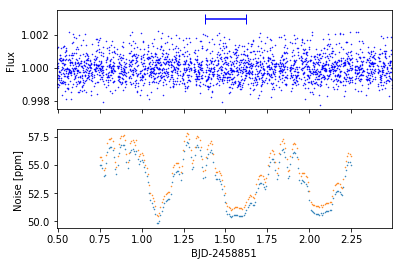

In [11]:
fig,ax=subplots(2,1,figsize=(6,4),sharex=True)
ax[0].set_xlim(min(time_raw),max(time_raw))
ax[0].plot(time_raw, flux_raw,'b.',ms=1)
ax[0].set_ylabel("Flux ".format(median(C)))
ax[0].set_ylim(0.9975,1.0035)
ax[0].errorbar(median(T),1.003,xerr=WIDTH_HOURS/24,
           capsize=5,color='b',ecolor='b')
ax[1].plot(T,N,'.',ms=1)
ax[1].set_ylabel("Noise [ppm] ".format(median(C)))
ax[1].set_xlabel("BJD-{}".format(int(min(BJD))));
ax[1].plot(T,Nsun,'.',ms=1)
ax[1].set_ylabel("Noise [ppm] ".format(median(C)))
ax[1].set_xlabel("BJD-{}".format(int(min(BJD))));


### Same test but with a gap
 Gaps are are shorter than width because I have not made the function transit_noise robust to empty input data yet.

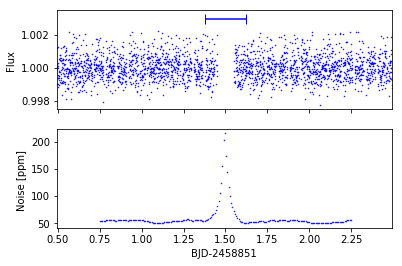

In [13]:
T = linspace(0.75, 2.25, 200)
Ngap = empty_like(T)
Fgap = empty_like(T)

i_gap = ((abs(time_raw-1.5) > 0.05).nonzero())[0]
time_gap = time_raw[i_gap]
flux_gap = flux_raw[i_gap]
error_gap = flux_err[i_gap]

for i,_t in enumerate(T):
    _n,_f = transit_noise(time_gap, flux_gap, error_gap,
                        T_0=_t, width=WIDTH_HOURS,h_1=h1, h_2=h2)
    Ngap[i] = _n
    Fgap[i] = _f

fig,ax=subplots(2,1,figsize=(6,4),sharex=True)
ax[0].set_xlim(min(time_raw),max(time_raw))
ax[0].plot(time_gap, flux_gap,'b.',ms=1)
ax[0].set_ylabel("Flux ".format(median(C)))
ax[0].set_ylim(0.9975,1.0035)
ax[0].errorbar(median(T),1.003,xerr=WIDTH_HOURS/24,
           capsize=5,color='b',ecolor='b')
ax[1].plot(T,Ngap,'b.',ms=1)
ax[1].set_ylabel("Noise [ppm] ".format(median(C)))
ax[1].set_xlabel("BJD-{}".format(int(min(BJD))));

&copy; Pierre Maxted, Keele University, 2019